In [1]:
import eQTLseq as _assoc

In [2]:
import sys as _sys
import pickle as _pkl
import warnings as _wrn
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

Fitting gene 12612 of 12613
540 genes did not converge
/Users/dimitris/Venvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/dimitris/Venvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


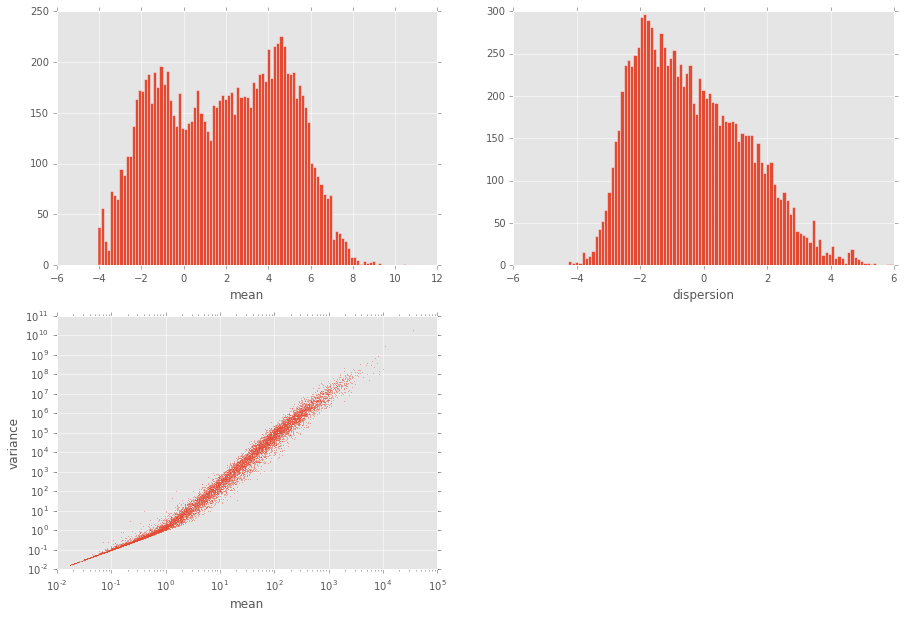

In [3]:
def fcn(fname):
    counts = _pnd.read_table(fname, index_col=0).values
    counts = counts[counts.sum(1)>0, :]  # remove zero-sum rows
    fit = _assoc.fit_nbinom_model(counts)
    print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
    idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
    pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}

    _plt.figure(figsize=(15,10))
    _plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
    _plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
    _plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');    

    return pars

##
pars = fcn('data/montpick_count_table_CEU.txt')

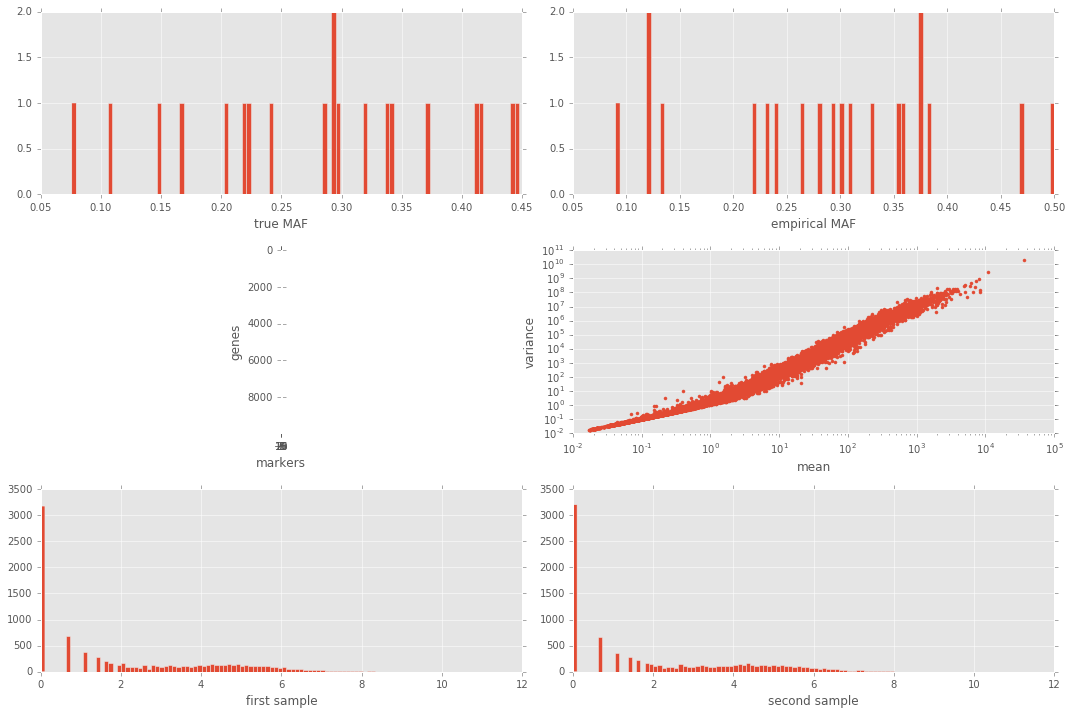

In [119]:
def fcn(n_samples=100, n_markers=20, n_markers_causal=1, n_genes=10000, n_genes_affected=1, MAF_range=[0.05, 0.5]):
    data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
    data_pheno = _assoc.simulate_eQTLs(data_geno['G'], pars['mu'], pars['phi'], 
                                       n_markers_causal=n_markers_causal, 
                                       n_genes=n_genes, n_genes_affected=n_genes_affected, s2=2)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
    _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
    _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][:,0]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][:,1]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return {**data_geno, **data_pheno}

##
data = fcn()

In [122]:
Z = data['Z'] / _assoc.calculate_norm_factors(data['Z'])
# Z = _assoc.transform_data(Z, kind='log')
res = _assoc.run(Z, data['G'], n_iters = 1000, mdl='NBinomial', scale=True, n_threads=1)

Starting...
Iteration 1000 of 1000
Done!


/Users/dimitris/Venvs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[nan, nan, nan, 0, 0, 0, 0]

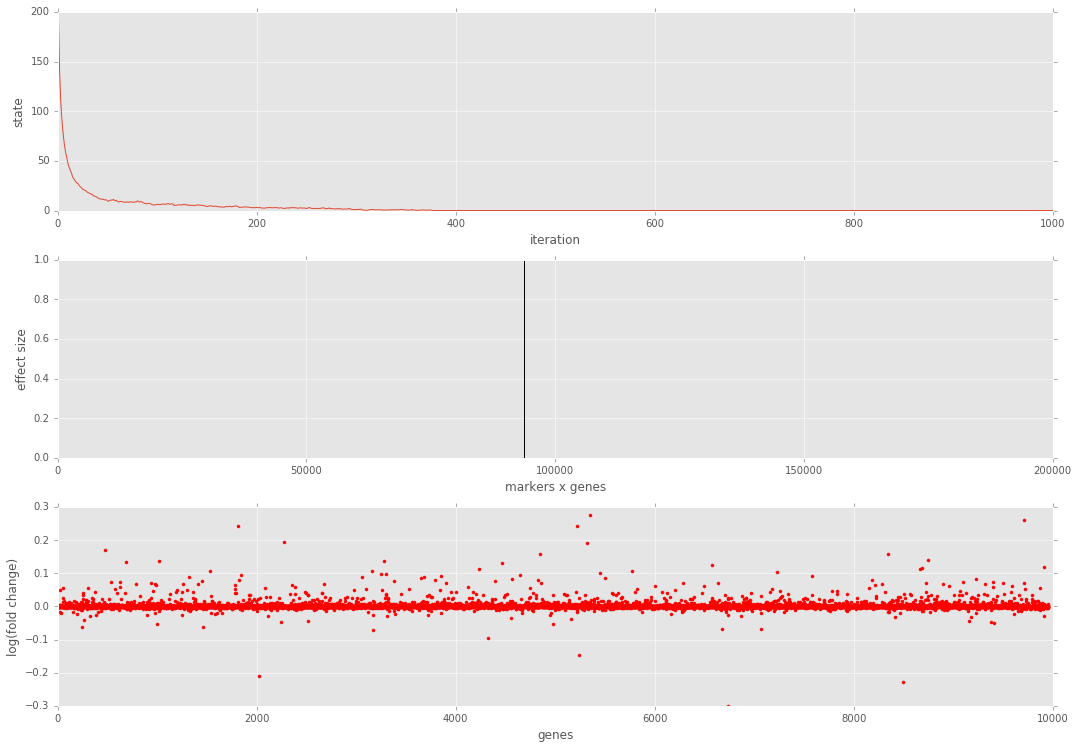

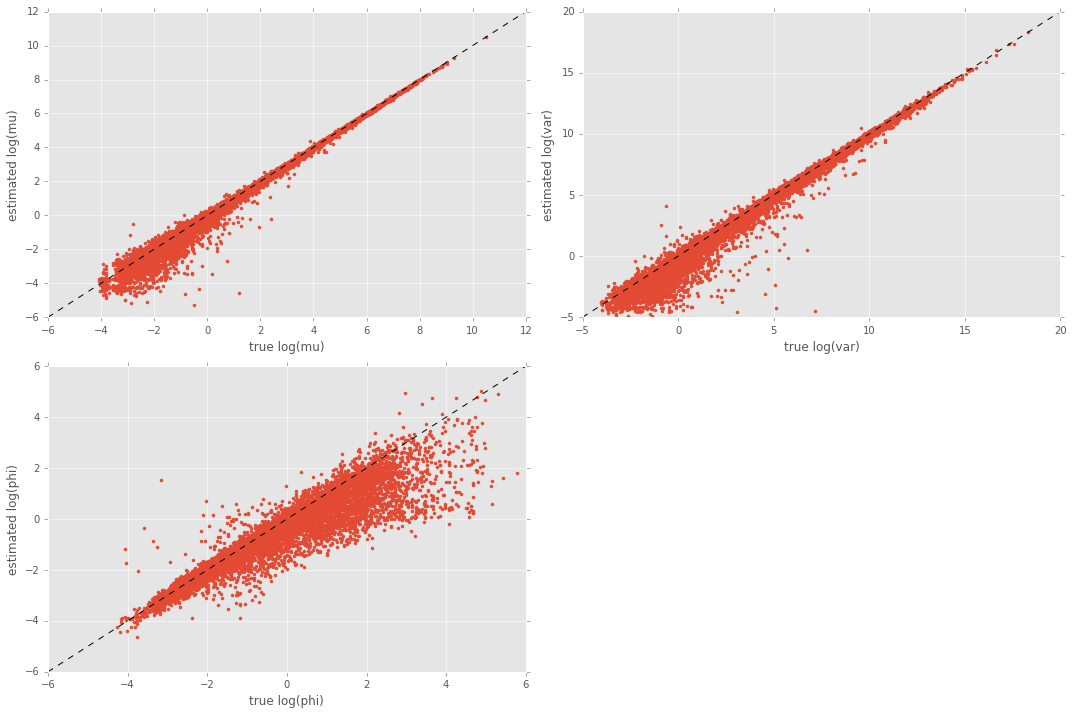

In [126]:
def fcn():
    _plt.figure(figsize = (15,10));
    _plt.subplot(3,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

    beta_estim = res['beta'] / _nmp.abs(res['beta']).sum()
    beta_true = data['beta'] / _nmp.abs(data['beta']).sum()
    n_genes, n_markers = beta_true.shape

    _plt.subplot(3,1,2); 
    _plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
    _plt.axhline(linestyle='--', color='k');
    _plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

    _plt.tight_layout()

    if 'Y' in res:
        _plt.subplot(3,1,3); 
        _plt.plot(_nmp.mean(res['Y'], 1), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(fold change)')

    if 'mu' in res:
        _plt.figure(figsize = (15,10))
        _plt.subplot(2,2,1)
        _plt.plot(_nmp.log(data['mu']), _nmp.log(res['mu']), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

        if 'phi' in res:
            var_tru = data['mu'] + data['phi'] * data['mu']**2
            var_est = res['mu'] + res['phi'] * res['mu']**2
            
            _plt.subplot(2,2,2)
            _plt.plot(_nmp.log(var_tru), _nmp.log(var_est), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

            _plt.subplot(2,2,3)
            _plt.plot(_nmp.log(data['phi']), _nmp.log(res['phi']), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')
                        
    _plt.tight_layout()

    return _assoc.calculate_metrics(res['beta'], data['beta'])

##
metrics = fcn()
[metrics[_] for _ in ['RSS', 'TPR', 'FDR', 'TP', 'FP', 'TN', 'FN']]

In [125]:
import itertools as _itr

In [174]:
N_SAMPLES = [50, 100, 200, 400, 800]
N_MARKERS = [int(_ / 5) for _ in N_SAMPLES]
N_GENES = [int(_ * 2) for _ in N_SAMPLES]

combs1 = [(N, M, G, 1, 1) for N, M, G in zip(N_SAMPLES, N_MARKERS, N_GENES)]
combs2 = [(N, M, G, 1, int(G/5)) for N, M, G in zip(N_SAMPLES, N_MARKERS, N_GENES)]
combs3 = [(N, M, G, int(M/5), 1) for N, M, G in zip(N_SAMPLES, N_MARKERS, N_GENES)]
combs4 = [(N, M, G, int(M/5), int(G/5)) for N, M, G in zip(N_SAMPLES, N_MARKERS, N_GENES)]

S2 = [1, 2, 4]
REP = range(1, 11)

combs = _itr.product(combs1+combs2+combs3+combs4, S2, REP)
combs = [_1 + (_2, _3) for _1, _2, _3 in combs]


combs1 = _itr.product(combs, ['Normal'], ['log', 'boxcox', 'blom'])
combs2 = _itr.product(combs, ['NBinomial', 'Poisson', 'Binomial'], ['none'])

combs = list(combs1)+list(combs2)

pars, mdl, trans = combs[0]
pars, mdl, trans

((50, 10, 100, 1, 1, 1, 1), 'Normal', 'log')

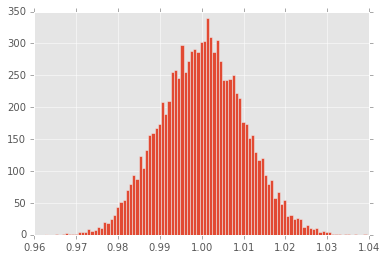

In [161]:
_plt.hist(_nmp.exp(0.01*_rnd.randn(10000)),100);

In [175]:
1 in [1,2,3,4]

True

ZeroDivisionError: division by zero